In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.enums import STATE_TO_CENSUS_REGION

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]

matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

# Data Preparation and Preprocessing

## Read data from PUDL DB and create some features 

In [5]:
%%time

FRC_EIA923_DATA_COLS = [
    "plant_id_eia",
    "report_date",
    "energy_source_code",
    "fuel_cost_per_mmbtu",
    "fuel_received_units",
    "fuel_mmbtu_per_unit",
]

logger.info("Query PUDL DB and build some features.")
plant_states = pd.read_sql("SELECT plant_id_eia, state FROM plants_entity_eia", pudl_engine)
fuel_group_eiaepm = pd.read_sql("SELECT code AS energy_source_code, fuel_group_eiaepm FROM energy_sources_eia", pudl_engine)

frc = (
    pd.read_sql("fuel_receipts_costs_eia923", pudl_engine, columns=FRC_EIA923_DATA_COLS)
    .merge(plant_states, on="plant_id_eia", how="left", validate="many_to_one")
    # Fuel group also cleanly categorizes fuel units, making fuel_mmbtu_per_unit more sensible.
    .merge(fuel_group_eiaepm, on="energy_source_code", how="left", validate="many_to_one")
    .pipe(apply_pudl_dtypes, group="eia")
    .assign(
        # There's no such thing as a free MMBTU
        fuel_cost_per_mmbtu=lambda x: x.fuel_cost_per_mmbtu.replace(0.0, np.nan),
        # Numerical representation of elapsed time
        elapsed_days=lambda x: (x.report_date - x.report_date.min()).dt.days,
        # Categorical months, to capture cyclical seasonal variability
        report_month=lambda x: x.report_date.dt.month,
        # Larger geographic area more likely to have lots of records
        census_region=lambda x: x.state.map(STATE_TO_CENSUS_REGION),
        # Need the total MMBTU for weighting the importance of the record
        # May also be predictive -- small deliveries seem more likely to be expensive
        fuel_received_mmbtu=lambda x: x.fuel_received_units * x.fuel_mmbtu_per_unit,
    )
    .drop(columns=["report_date", "fuel_received_units"])
    .convert_dtypes(convert_floating=False)
)

# The HistGBR model and OrdinalEncoder are supposedly fine with NA values but...
string_cols = frc.select_dtypes("string").columns
frc.loc[:, string_cols] = frc[string_cols].fillna("NULL")

Query PUDL DB and build some features.
CPU times: user 2.96 s, sys: 99.9 ms, total: 3.06 s
Wall time: 3.06 s


In [6]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571400 entries, 0 to 571399
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   plant_id_eia         571400 non-null  Int64  
 1   energy_source_code   571400 non-null  string 
 2   fuel_cost_per_mmbtu  381423 non-null  float64
 3   fuel_mmbtu_per_unit  571400 non-null  float64
 4   state                571400 non-null  string 
 5   fuel_group_eiaepm    571400 non-null  string 
 6   elapsed_days         571400 non-null  Int64  
 7   report_month         571400 non-null  Int64  
 8   census_region        571400 non-null  string 
 9   fuel_received_mmbtu  571400 non-null  float64
dtypes: Int64(3), float64(3), string(4)
memory usage: 49.6 MB


## Split the data into different functional parts...

In [7]:
# Records where we're missing the target value:
frc_to_predict = frc[frc.fuel_cost_per_mmbtu.isna()]

# Records where we have the target value:
frc_train_test = frc[frc.fuel_cost_per_mmbtu.notna()]

# The data we're going to use to predict:
frc_data = frc_train_test.drop(columns=["fuel_cost_per_mmbtu"])

# The target we're trying to predict:
frc_target = frc_train_test["fuel_cost_per_mmbtu"]

# Relative importance of each of the records:
sample_weight=frc_data["fuel_received_mmbtu"]

## Build a Pipeline

In [8]:
cat_cols = [
#   "energy_source_code",
    "fuel_group_eiaepm",
    "state",
    "report_month",
#   "census_region",
]

num_cols = [
    "plant_id_eia", 
    "elapsed_days",
    "fuel_mmbtu_per_unit",
#   "fuel_received_mmbtu",
]

ord_enc = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="string"),
    ),
    remainder="passthrough",
)

pipe = Pipeline([
    ("ord_enc", ord_enc),
    ("hist_gbr", HistGradientBoostingRegressor(loss="absolute_error", max_iter=1_000)),
])

## Set up Grid Search Cross Validation

In [31]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=5, random_state=0)
# Split based on Plant ID to avoid plant information leaking between test / training
# This is mostly just an example. Not sure it's actually a good idea.
gss_split = gss.split(frc_train_test, groups=frc_train_test["state"])
param_grid = {
    "hist_gbr__max_depth": [7,],
    "hist_gbr__max_leaf_nodes": [2**7],
    "hist_gbr__learning_rate": [0.1],
    "hist_gbr__min_samples_leaf": [25],
}

# Define hyperparameter space to search:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=gss_split, n_jobs=-1, scoring='neg_median_absolute_error')

In [32]:
%%time
# Train up all the models and store the results.
# Weight samples by `sample_weight` during training.
result = grid.fit(
        X=frc_train_test[cat_cols+num_cols],
        y=frc_target,
        hist_gbr__sample_weight=sample_weight,
    )

/home/tpb/miniconda3/envs/analysis-pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/tpb/miniconda3/envs/analysis-pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/tpb/miniconda3/envs/analysis-pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/tpb/miniconda3/envs/analysis-pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names th

CPU times: user 1min 19s, sys: 660 ms, total: 1min 20s
Wall time: 3min 21s


## Use the best estimator to predict missing fuel prices

In [33]:
cv_results = pd.DataFrame(result.cv_results_)

In [34]:
result.best_score_

-0.5078756537397606

In [35]:
cv_results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hist_gbr__learning_rate,param_hist_gbr__max_depth,param_hist_gbr__max_leaf_nodes,param_hist_gbr__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,62.994186,15.276459,6.743913,1.665196,0.1,7,128,25,"{'hist_gbr__learning_rate': 0.1, 'hist_gbr__ma...",-0.48976,-0.437022,-0.599411,-0.522987,-0.490198,-0.507876,0.053419,1


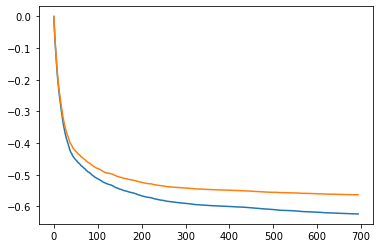

In [36]:
reg = grid.best_estimator_['hist_gbr']
plt.plot(range(reg.n_iter_), np.log10(-1* reg.train_score_[1:]))
plt.plot(range(reg.n_iter_), np.log10(-1* reg.validation_score_[1:]))

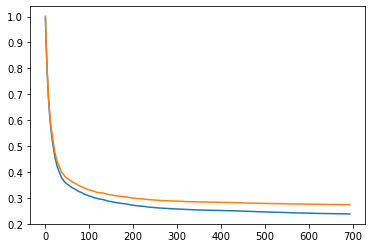

In [37]:
reg = grid.best_estimator_['hist_gbr']
plt.plot(range(reg.n_iter_), (-1* reg.train_score_[1:]))
plt.plot(range(reg.n_iter_), (-1* reg.validation_score_[1:]))

In [38]:
predicted_fuel_costs = grid.best_estimator_.predict(X=frc_train_test[cat_cols+num_cols])
frc_predicted = (
    frc_train_test.copy()
    .assign(predict=predicted_fuel_costs)
)
frc_predicted['error'] = frc_predicted['predict'] - frc_predicted['fuel_cost_per_mmbtu']
frc_predicted['rel_error'] = frc_predicted['error'] / frc_predicted['fuel_cost_per_mmbtu']

frc_predicted

,plant_id_eia,energy_source_code,fuel_cost_per_mmbtu,fuel_mmbtu_per_unit,state,fuel_group_eiaepm,elapsed_days,report_month,census_region,fuel_received_mmbtu,predict,error,rel_error
0,3,BIT,2.135,23.100,AL,coal,0,1,ESC,5992417.200,2.134849,-0.000151,-0.000071
1,3,BIT,2.115,22.800,AL,coal,0,1,ESC,1191094.800,2.228322,0.113322,0.053580
2,3,NG,8.631,1.039,AL,natural_gas,0,1,ESC,2892180.141,8.641805,0.010805,0.001252
3,7,BIT,2.776,24.610,AL,coal,0,1,ESC,625020.170,2.560268,-0.215732,-0.077713
4,7,BIT,3.381,24.446,AL,coal,0,1,ESC,18676.744,2.243066,-1.137934,-0.336567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571391,60927,NG,3.101,1.025,LA,natural_gas,4718,12,WSC,2392705.675,3.218809,0.117809,0.037991
571392,60927,NG,2.728,1.014,LA,natural_gas,4718,12,WSC,81995.082,3.137387,0.409387,0.150069
571393,60928,NG,2.576,1.020,LA,natural_gas,4718,12,WSC,86226.720,3.136702,0.560702,0.217664
571396,61643,NG,3.058,1.000,TX,natural_gas,4718,12,WSC,61368.000,3.007434,-0.050566,-0.016536


In [39]:
frc_predicted['error'].abs().mean()

8.162486506463205

<AxesSubplot:>

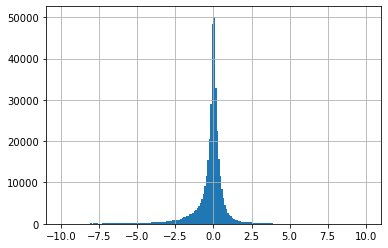

In [40]:
frc_predicted['error'].hist(bins=200, range=(-10,10))

<AxesSubplot:>

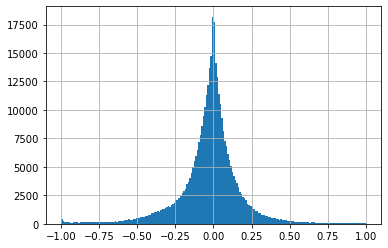

In [41]:
frc_predicted['rel_error'].hist(bins=200, range=(-1,1))

In [42]:
frc_predicted['rel_error'].describe()

count    381423.000000
mean         -0.008655
std           0.961217
min         -95.155494
25%          -0.097233
50%          -0.008785
75%           0.063695
max         246.544517
Name: rel_error, dtype: float64

In [44]:
frc_predicted['error'].describe()

count    381423.000000
mean         -7.759143
std         910.056722
min     -330989.516633
25%          -0.384855
50%          -0.025235
75%           0.186839
max          74.463018
Name: error, dtype: float64

In [20]:
frc.loc[frc['fuel_cost_per_mmbtu'].idxmax(),:]

plant_id_eia                 55306
energy_source_code              NG
fuel_cost_per_mmbtu      330991.58
fuel_mmbtu_per_unit          1.035
state                           AZ
fuel_group_eiaepm      natural_gas
elapsed_days                  4657
report_month                    10
census_region                  MTN
fuel_received_mmbtu         58.995
Name: 565079, dtype: object

<AxesSubplot:xlabel='fuel_cost_per_mmbtu', ylabel='predict'>

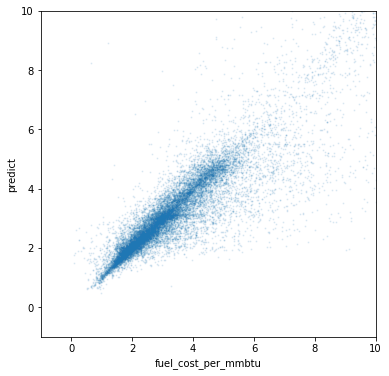

In [45]:
frc_predicted.sample(20_000).plot.scatter(
    x='fuel_cost_per_mmbtu',
    y='predict',
    figsize=(6,6),
    xlim=(-1,10),
    ylim=(-1,10),
    s=1,
    alpha=0.1
)

<AxesSubplot:>

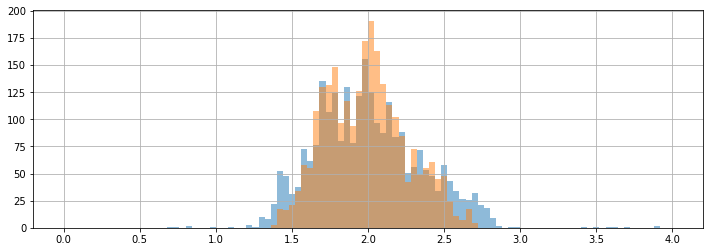

In [46]:
ar_coal = frc_predicted.loc[frc_predicted['state'].eq('AR') & frc_predicted['fuel_group_eiaepm'].eq('coal'),:]
hist_params = dict(range=(0,4), bins=100, figsize=(12,4), alpha=0.5)
ar_coal['fuel_cost_per_mmbtu'].hist(**hist_params) # Reported
ar_coal['predict'].hist(**hist_params) # predicted

<AxesSubplot:>

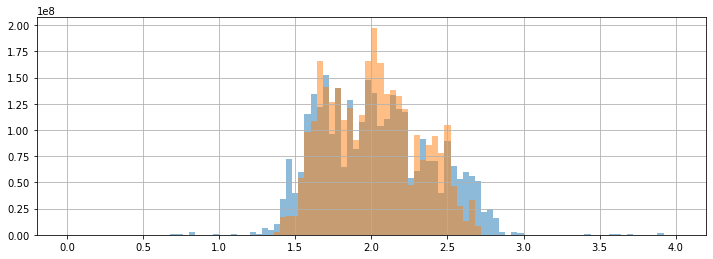

In [47]:
hist_params = dict(range=(0,4), bins=100, figsize=(12,4), alpha=0.5, weights=ar_coal['fuel_received_mmbtu'])
ar_coal['fuel_cost_per_mmbtu'].hist(**hist_params) # Reported
ar_coal['predict'].hist(**hist_params) # predicted

# Feature Importance

In [48]:
from sklearn.inspection import permutation_importance

In [49]:
%%time
imp = permutation_importance(grid.best_estimator_,
                             X=frc_train_test[cat_cols+num_cols],
                             y=frc_train_test['fuel_cost_per_mmbtu'],
                             scoring='neg_median_absolute_error',
                             random_state=42,
                             n_repeats=5,
                             max_samples=0.1
                            )

CPU times: user 1min 43s, sys: 215 ms, total: 1min 44s
Wall time: 36.4 s


<BarContainer object of 6 artists>

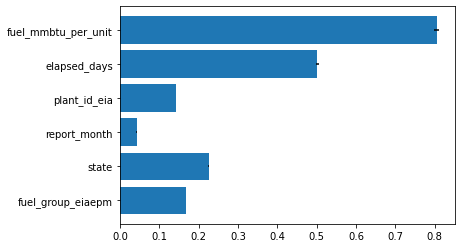

In [50]:
plt.barh(range(len(cat_cols+num_cols)), imp.importances_mean, xerr=imp.importances_std, tick_label=cat_cols+num_cols)

# External Validation

In [114]:
eia_epm_state = pd.read_csv('./eia_epm_prices_states.csv', parse_dates=['date'])
eia_epm_regional = pd.read_csv('./eia_epm_prices_regions.csv', parse_dates=['date'])
eia_epm_national = pd.read_csv('./eia_epm_prices_national.csv', parse_dates=['date'])

In [115]:
# harmonize categories
for df in [eia_epm_state, eia_epm_regional, eia_epm_national]:
    df['fuel'] = df['fuel'].replace({'gas': 'natural_gas', 'petcoke': 'petroleum_coke', 'oil': 'petroleum'})

In [58]:
from pudl.metadata.enums import STATE_TO_CENSUS_REGION, US_STATES_TERRITORIES

In [73]:
state_mappings = pd.Series(STATE_TO_CENSUS_REGION, name='census_region_abbrev').to_frame().reset_index().rename(columns={'index': 'state_abbrev'})
state_mappings['state_name'] = state_mappings['state_abbrev'].map(US_STATES_TERRITORIES)

In [74]:
census_names_map = {
    'ENC': 'East North Central',
    'ESC': 'East South Central',
    'MAT': 'Middle Atlantic',
    'MTN': 'Mountain',
    'NEW': 'New England',
    'PCC': 'Pacific Contiguous',
    'PCN': 'Pacific Noncontiguous',
    'SAT': 'South Atlantic',
    'WNC': 'West North Central',
    'WSC': 'West South Central',
}

In [75]:
state_mappings['region_name'] = state_mappings['census_region_abbrev'].map(census_names_map)

In [80]:
state_mappings = state_mappings.astype('category')
state_mappings

,state_abbrev,census_region_abbrev,state_name,region_name
0,WI,ENC,Wisconsin,East North Central
1,MI,ENC,Michigan,East North Central
2,IL,ENC,Illinois,East North Central
3,IN,ENC,Indiana,East North Central
4,OH,ENC,Ohio,East North Central
5,KY,ESC,Kentucky,East South Central
6,TN,ESC,Tennessee,East South Central
7,MS,ESC,Mississippi,East South Central
8,AL,ESC,Alabama,East South Central
9,NY,MAT,New York,Middle Atlantic


In [82]:
frc_predicted = frc_predicted.merge(state_mappings.drop(columns='census_region_abbrev'), left_on='state', right_on='state_abbrev')

In [87]:
frc_predicted.columns

Index(['plant_id_eia', 'energy_source_code', 'fuel_cost_per_mmbtu', 'fuel_mmbtu_per_unit', 'state', 'fuel_group_eiaepm', 'elapsed_days', 'report_month', 'census_region', 'fuel_received_mmbtu', 'predict', 'error', 'rel_error', 'state_abbrev', 'state_name', 'region_name'], dtype='object')

In [125]:
def fuel_weighted_avg(df, col_to_avg: str):
    return (df[col_to_avg] * df['fuel_received_mmbtu']).sum() / df['fuel_received_mmbtu'].sum()

In [93]:
frc_predicted['report_date'] = frc_predicted['elapsed_days'].apply(pd.Timedelta, unit='d') + pd.Timestamp('2008-01-01')

In [129]:
grp = frc_predicted.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [126]:
state_level = (grp.apply(fuel_weighted_avg, col_to_avg='fuel_cost_per_mmbtu')
               .rename('frc_reported')
              )

In [131]:
state_level = state_level.to_frame().join(grp.apply(fuel_weighted_avg, col_to_avg='predict').rename('frc_modeled'))

In [132]:
state_epm = pd.to_numeric(eia_epm_state.rename(
    columns=dict(zip(['region', 'fuel', 'date'], ['state_name', 'fuel_group_eiaepm', 'report_date']))
)
 .set_index(['state_name', 'fuel_group_eiaepm', 'report_date'])
 ['Electric Power Sector'].rename('eia_epm'),
                          errors='coerce'
                         )

In [135]:
#state_level = 
state_level.join(state_epm, how='outer').dropna(how='all')

frc_reported  frc_modeled  eia_epm
state_name fuel_group_eiaepm report_date                                    
Alabama    coal              2006-09-01            NaN          NaN     2.11
                             2006-10-01            NaN          NaN     2.35
                             2006-11-01            NaN          NaN     2.14
                             2007-01-01            NaN          NaN     2.05
                             2007-02-01            NaN          NaN     2.02
...                                                ...          ...      ...
Wyoming    petroleum         2020-08-01      11.286045    10.680823    11.29
                             2020-09-01      10.139916    10.807862    10.14
                             2020-10-01       9.784458    10.998137     9.78
                             2020-11-01      12.577212    10.724961    12.58
                             2020-12-01      12.212331    11.020092    12.21

[21246 rows x 3 columns]